<a href="https://colab.research.google.com/github/NolanSmyth/deepMIDI/blob/master/midiMusicV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependences

In [209]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

import numpy as np
import os
import glob
from tqdm import tqdm
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import models
from keras import layers
from music21 import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [399]:
path = '/content/drive/My Drive/midi/*.mid'
def get_notes(path):

  ''' extracts all notes from midi files stored in drive given
  path (str) - path location 

  returns
  notes - list of all notes from all midi files
  '''

  notes = []
  offsets = []
  midfs = glob.glob(path)
  for midf in midfs:
    print('loading: ', midf)
    notes_to_parse = None
    midi = converter.parse(midf)
    try:
      s2 = instrument.partitionByInstrument(midi)
      notes_to_parse = s2.parts[0].recurse()
    except:
      notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
      if isinstance(element, note.Note):
        notes.append(str(element.pitch))
        offsets.append(float(element.offset))
      elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))
        offsets.append(float(element.offset))
        
  return notes, offsets  
notes, offsets = get_notes(path)

loading:  /content/drive/My Drive/midi/fuguecm.mid
loading:  /content/drive/My Drive/midi/fuguegm.mid
loading:  /content/drive/My Drive/midi/tri2.mid
loading:  /content/drive/My Drive/midi/unfin.mid
loading:  /content/drive/My Drive/midi/tri1.mid
loading:  /content/drive/My Drive/midi/reg2.mid
loading:  /content/drive/My Drive/midi/mir2.mid
loading:  /content/drive/My Drive/midi/mir1.mid
loading:  /content/drive/My Drive/midi/reg1.mid
loading:  /content/drive/My Drive/midi/inver2.mid
loading:  /content/drive/My Drive/midi/inver1.mid
loading:  /content/drive/My Drive/midi/dou1.mid
loading:  /content/drive/My Drive/midi/dou2.mid
loading:  /content/drive/My Drive/midi/cnt3.mid
loading:  /content/drive/My Drive/midi/cnt1.mid
loading:  /content/drive/My Drive/midi/can3.mid
loading:  /content/drive/My Drive/midi/can4.mid
loading:  /content/drive/My Drive/midi/cnt2.mid
loading:  /content/drive/My Drive/midi/can2.mid
loading:  /content/drive/My Drive/midi/can1.mid


In [400]:
offsets[0:10]
rel_offsets = []
for i in range(len(offsets)-1):
  rel_offsets.append(abs(round(offsets[i+1] - offsets[i],3)))

In [401]:
# create a dictionary mapping each name to a unique integer
pitch_names = sorted(set(notes))
note_to_int = {note:i for i, note in enumerate(pitch_names)}
# create mapping from indices back to note name
int_to_note = np.array(pitch_names)
num_unique_notes = len(pitch_names)

# create dictionary mapping each offset to a unique integer
# i think I might only care about relative offset. But try this first.
unique_offsets = [str(element) for element in sorted(set(offsets))]
offset_to_int = {offset:i for i,offset in enumerate(unique_offsets)}
# create mapping from indices back to offset
int_to_offset = np.array(unique_offsets)
num_unique_offsets = len(unique_offsets)

unique_rel_offsets = [str(element) for element in sorted(set(rel_offsets))]
rel_offset_to_int = {offset:i for i,offset in enumerate(unique_rel_offsets)}
# create mapping from indices back to offset
int_to_rel_offset = np.array(unique_rel_offsets)
num_unique_rel_offsets = len(unique_rel_offsets)

print('There are', num_unique_notes, 'unique notes in the dataset\n')
print('and', num_unique_offsets, 'unique offsets')
print('and', num_unique_rel_offsets, 'relative unique offsets')

There are 53 unique notes in the dataset

and 3759 unique offsets
and 60 relative unique offsets


In [49]:
len(unique_rel_offsets)

8

In [402]:
def vectorize_notes(notes):
  # get names of all pitches used
  
  vectorized_notes = np.array([note_to_int[note] for note in notes])
  return vectorized_notes
vectorized_notes = vectorize_notes(notes)

def vectorize_offsets(offsets):
  vectorized_offsets = np.array([offset_to_int[offset] for offset in offsets])
  return vectorized_offsets
vectorized_offsets = vectorize_offsets(unique_offsets)

def vectorize_rel_offsets(offsets):
  vectorized_rel_offsets = np.array([rel_offset_to_int[str(offset)] for offset in rel_offsets])
  return vectorized_rel_offsets
vectorized_rel_offsets = vectorize_rel_offsets(unique_rel_offsets)

In [60]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(notes[:10]), vectorized_notes[:10]))

['B4', 'G3', 'F#3', 'E5', 'D5', 'G3', 'E5', 'E3', 'F#3', 'D5'] ---- characters mapped to int ----> [0 1 2 3 4 5 6 7 8 9]


In [333]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(unique_offsets[:10]), vectorized_offsets[:10]))

['0.0', '0.5', '1.0', '1.5', '2.0', '2.25', '2.5', '2.75', '3.0', '3.5'] ---- characters mapped to int ----> [0 1 2 3 4 5 6 7 8 9]


In [51]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(unique_rel_offsets[:10]), vectorized_rel_offsets[:10]))

['0.0', '0.083', '0.167', '0.25', '0.333', '0.5', '0.75', '1.0'] ---- characters mapped to int ----> [0 1 2 3 4 5 6 7]


In [403]:
def get_batch_notes(vectorized_notes, seq_length, batch_size):

  ''' create training exmaples for LSTM given
  vectorized_notes - a list ints representing all the notes from inputed midi files
  seq_length - length of each training sequence
  batch_size - size of each batch

  returns:
  x_batch - inputs
  y_batch - true labels for training
  '''

  # length of vectorized notes
  n = vectorized_notes.shape[0] - 1
  # randomly choose starting indices for the examples in training batch
  idx = np.random.choice(n - seq_length, batch_size)

  # create input and output sequences to feed into neural net
  input_batch = [vectorized_notes[i : i+seq_length] for i in idx]
  output_batch = [vectorized_notes[i+1 : i+seq_length+1] for i in idx]
  
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch


In [334]:
def get_batch_offsets(vectorized_offsets, seq_length, batch_size):

  ''' create training exmaples for LSTM given
  vectorized_notes - a list ints representing all the notes from inputed midi files
  seq_length - length of each training sequence
  batch_size - size of each batch

  returns:
  x_batch - inputs
  y_batch - true labels for training
  '''

  # length of vectorized notes
  n = vectorized_offsets.shape[0] - 1
  # randomly choose starting indices for the examples in training batch
  idx = np.random.choice(n - seq_length, batch_size)

  # create input and output sequences to feed into neural net
  input_batch = [vectorized_offsets[i : i+seq_length] for i in idx]
  output_batch = [vectorized_offsets[i+1 : i+seq_length+1] for i in idx]

  #Experiment with normalization
  # input_batch = [input_batch[i] / float(num_unique_offsets) for i in range(len(input_batch))]
  # output_batch = [output_batch[i] / float(num_unique_offsets) for i in range(len(output_batch))]
  
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch

In [335]:
vectorized_offsets.shape

(1813,)

In [284]:
def get_batch_rel_offsets(vectorized_rel_offsets, seq_length, batch_size):

  ''' create training exmaples for LSTM given
  vectorized_notes - a list ints representing all the notes from inputed midi files
  seq_length - length of each training sequence
  batch_size - size of each batch

  returns:
  x_batch - inputs
  y_batch - true labels for training
  '''

  # length of vectorized notes
  n = vectorized_rel_offsets.shape[0] - 1
  # randomly choose starting indices for the examples in training batch
  idx = np.random.choice(n - seq_length, batch_size)

  # create input and output sequences to feed into neural net
  input_batch = [vectorized_rel_offsets[i : i+seq_length] for i in idx]
  output_batch = [vectorized_rel_offsets[i+1 : i+seq_length+1] for i in idx]

  #Experiment with normalization
  # input_batch = [input_batch[i] / float(num_unique_offsets) for i in range(len(input_batch))]
  # output_batch = [output_batch[i] / float(num_unique_offsets) for i in range(len(output_batch))]
  
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch

In [285]:
x_batch, y_batch = get_batch_notes(vectorized_notes, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(int_to_note[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(int_to_note[target_idx])))
# This isn't the most useful anymore

Step   0
  input: 47 ('G5')
  expected output: 39 ('F5')
Step   1
  input: 39 ('F5')
  expected output: 21 ('D3')
Step   2
  input: 21 ('D3')
  expected output: 43 ('G#5')
Step   3
  input: 43 ('G#5')
  expected output: 17 ('C4')
Step   4
  input: 17 ('C4')
  expected output: 47 ('G5')


In [40]:
x_batch, y_batch = get_batch_rel_offsets(vectorized_rel_offsets, seq_length=5, batch_size=1)
print(x_batch)
print(y_batch)

[[253 254 255 256 257]]
[[254 255 256 257 258]]


In [24]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )


In [649]:
def create_network(vocab_size, embedding_dim, rnn_units, batch_size):
  ''' create the structure of the neural network given
  net_in - input for LSTM
  net_out - output for LSTM
  '''

  # model = tf.keras.Sequential([
  # # tf.keras.layers.Embedding(num_unique_notes, embedding_dim, batch_input_shape=[batch_size, None]),
  # tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
  # LSTM(rnn_units),
  # tf.keras.layers.Dropout(0.2),
  # LSTM(rnn_units),
  # tf.keras.layers.Dense(vocab_size)
  # ])

  # return model

  model = models.Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))
  model.add(LSTM(rnn_units))
  model.add(layers.Dropout(0.2))
  model.add(LSTM(rnn_units))
  model.add(layers.Dropout(0.2))
  model.add(LSTM(rnn_units))
  model.add(layers.Dense(vocab_size))

  return model


In [517]:
vocab_size = num_unique_notes 
model_notes = create_network(num_unique_notes, embedding_dim=256, rnn_units=512, batch_size=32)
model_offsets = create_network(num_unique_offsets, embedding_dim=256, rnn_units=512, batch_size=32)
model_rel_offsets = create_network(num_unique_rel_offsets, embedding_dim=256, rnn_units=512, batch_size=32)
model_notes.summary()
model_rel_offsets.summary()

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_130 (Embedding)    (32, None, 256)           13568     
_________________________________________________________________
lstm_296 (LSTM)              (32, None, 512)           1574912   
_________________________________________________________________
dense_130 (Dense)            (32, None, 53)            27189     
Total params: 1,615,669
Trainable params: 1,615,669
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_132 (Embedding)    (32, None, 256)           15360     
_________________________________________________________________
lstm_298 (LSTM)              (32, None, 512)           1574912   
__________________

In [406]:
x, y = get_batch_rel_offsets(vectorized_rel_offsets, seq_length=5, batch_size=32)
pred = model_rel_offsets(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length, features)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 5)  # (batch_size, sequence_length, features)
Prediction shape:  (32, 5, 60) # (batch_size, sequence_length, vocab_size)


In [289]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices


array([2, 2, 4, 5, 5])

In [290]:
print("Input: \n", repr(" ".join(int_to_rel_offset[x[0]])))
print()
print("Next Char Predictions: \n", repr(" ".join(int_to_rel_offset[sampled_indices])))

Input: 
 '0.5 0.0 0.5 0.0 0.5'

Next Char Predictions: 
 '0.167 0.167 0.333 0.5 0.5'


In [407]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

# def compute_loss(labels, logits):
#   loss1 = tf.keras.losses.sparse_categorical_crossentropy(labels[:,:,0], logits, from_logits=True)
#   loss2 = tf.keras.losses.sparse_categorical_crossentropy(labels[:,:,1], logits, from_logits=True)
#   return (loss1 + loss2)/2

# example_batch_loss = compute_loss(y, pred)
# # example_batch_loss = compute_loss('''TODO''', '''TODO''') # TODO

# print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [650]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 3000  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
seq_length = 25  # Experiment between 50 and 500
seq_length_rhythm = 50  # Experiment between 50 and 500
learning_rate = 5e-4  # Experiment between 1e-5 and 1e-1
learning_rate_rhythm = 1e-3

# Model parameters: 
vocab_size = len(pitch_names)
embedding_dim = 64 
rnn_units = 512  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [651]:
model_notes = create_network(num_unique_notes, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model_notes(x) 
  
    loss = compute_loss(y, y_hat) 

  # Now, compute the gradients 
  grads = tape.gradient(loss, model_notes.trainable_variables) # TODO
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model_notes.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  # x_batch, y_batch = get_batch(vectorized_notes, seq_length, batch_size)
  x_batch, y_batch = get_batch_notes(vectorized_notes, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model_notes.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model_notes.save_weights(checkpoint_prefix)

100%|██████████| 3000/3000 [01:16<00:00, 39.16it/s]


In [652]:
model_notes = create_network(num_unique_notes, embedding_dim, rnn_units, batch_size=1) 

# Restore the model weights for the last checkpoint after training
model_notes.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_notes.build(tf.TensorShape([1, None]))

model_notes.summary()

Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_170 (Embedding)    (1, None, 64)             3392      
_________________________________________________________________
lstm_390 (LSTM)              (1, None, 512)            1181696   
_________________________________________________________________
dropout_220 (Dropout)        (1, None, 512)            0         
_________________________________________________________________
lstm_391 (LSTM)              (1, None, 512)            2099200   
_________________________________________________________________
dropout_221 (Dropout)        (1, None, 512)            0         
_________________________________________________________________
lstm_392 (LSTM)              (1, None, 512)            2099200   
_________________________________________________________________
dense_170 (Dense)            (1, None, 53)          

In [653]:
model_rel_offsets = create_network(num_unique_rel_offsets, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate_rhythm)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    y_hat = model_rel_offsets(x) 
  
    loss = compute_loss(y, y_hat) 

  # Now, compute the gradients 
  grads = tape.gradient(loss, model_rel_offsets.trainable_variables) # TODO
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model_rel_offsets.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  # x_batch, y_batch = get_batch(vectorized_notes, seq_length, batch_size)
  x_batch, y_batch = get_batch_rel_offsets(vectorized_rel_offsets, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model_rel_offsets.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model_rel_offsets.save_weights(checkpoint_prefix)

100%|██████████| 3000/3000 [01:14<00:00, 40.08it/s]


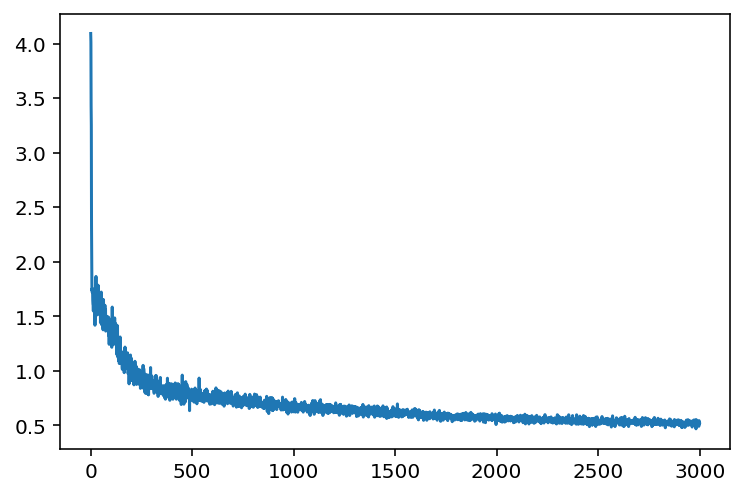

In [654]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

In [655]:
model_rel_offsets = create_network(num_unique_rel_offsets, embedding_dim, rnn_units, batch_size=1) 

# Restore the model weights for the last checkpoint after training
model_rel_offsets.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_rel_offsets.build(tf.TensorShape([1, None]))

model_rel_offsets.summary()

Model: "sequential_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_172 (Embedding)    (1, None, 64)             3840      
_________________________________________________________________
lstm_396 (LSTM)              (1, None, 512)            1181696   
_________________________________________________________________
dropout_224 (Dropout)        (1, None, 512)            0         
_________________________________________________________________
lstm_397 (LSTM)              (1, None, 512)            2099200   
_________________________________________________________________
dropout_225 (Dropout)        (1, None, 512)            0         
_________________________________________________________________
lstm_398 (LSTM)              (1, None, 512)            2099200   
_________________________________________________________________
dense_172 (Dense)            (1, None, 60)          

In [660]:
x, y = get_batch_rel_offsets(vectorized_rel_offsets, seq_length=10, batch_size=1)
pred = model_rel_offsets(x)
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

print("Input: \n", repr(" ".join(int_to_rel_offset[x[0]])))
print()
print("Next Char Predictions: \n", repr(" ".join(int_to_rel_offset[sampled_indices])))

Input: 
 '0.25 0.0 0.25 0.0 0.25 0.0 0.25 0.0 0.25 0.0'

Next Char Predictions: 
 '0.25 0.75 0.25 0.25 0.0 0.25 0.0 0.25 0.0 0.25'


In [528]:
def generate_notes(model, start_string, generation_length=100):

  input_eval = [note_to_int[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval,0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(int_to_note[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ' '.join(text_generated))

def generate_offsets(model, start_string, generation_length=100):

  input_eval = [offset_to_int[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval,0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(int_to_offset[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ' '.join(text_generated))

def generate_rel_offsets(model, start_string, generation_length=100):

  input_eval = [rel_offset_to_int[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval,0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(int_to_offset[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ' '.join(text_generated))

In [787]:
generated_notes = generate_notes(model_notes, start_string=np.random.choice(notes)+ ' ', generation_length=140)

100%|██████████| 140/140 [00:01<00:00, 106.76it/s]


In [801]:
generated_rel_offsets = generate_rel_offsets(model_rel_offsets, start_string=str(np.random.choice(rel_offsets))+ ' ', generation_length=140)

100%|██████████| 140/140 [00:01<00:00, 105.89it/s]


In [799]:
def create_midi(generated_text, offsets=None):
  '''Converts the output from the prediction into notes and then creates a midi 
  file from the notes

  returns Stream
  '''

  default_note_spacing = 0.5
  scale = .4

  if offsets == None:
    offsets_temp = np.arange(0, len(generated_text), default_note_spacing) 
  else:
    offset = 0
    offsets_temp = [float(num)*scale for num in offsets]
    offsets_temp = [offsets_temp[i] - min(offsets_temp) for i in range(len(offsets))]
  output_notes = []

  for i, pattern in enumerate(generated_text):
      if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
          new_note = note.Note(int(current_note))
          new_note.storedInstrument = instrument.Piano()
          notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
      else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        output_notes.append(new_note)
      
      offset = offset + offsets_temp[i]

  midi_stream = stream.Stream(output_notes)
  return midi_stream

In [ ]:
#To play midi in notebook
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio

In [ ]:
#from first original midi file loaded
midi_orig_test = create_midi(notes[0:100], offsets[0:100])
midi_orig_test.write('midi', fp='orig_output.mid')
FluidSynth("font.sf2").midi_to_audio('orig_output.mid', 'test_orig.wav')
Audio("test_orig.wav")

In [802]:
#output
# midi_stream = create_midi(generated_notes.split(), generated_offsets.split())
midi_stream = create_midi(generated_notes.split(), generated_rel_offsets.split())
midi_stream.write('midi', fp='test_output.mid')
FluidSynth("font.sf2").midi_to_audio('test_output.mid', 'test_output.wav')
Audio("test_output.wav")